### 본 매뉴얼은 디지털신기술팀에서 개발한 실시간 주택시장 실거래가격지수 계산 파이프라인에 대해 다룬다.

# **실시간 주택시장 실거래가격지수(BReiT/CS index)** <font size=3> 디지털혁신실(디지털신기술팀) </font>

#### bok-da 라이브러리와 라이브러리 내 주택시장 실거래가격지수 계산을 위한 함수를 모아놓은 `house.py` 모듈을 호출한다.

In [1]:
import bok_da as bd
from bok_da.project.housing import house

위 셀과 같이 `from bok_da.project.housing import house`로 모듈을 호출하는 경우, `house.func()`, `house.variable`과 같은 방법으로 모듈 내 함수와 변수를 사용할 수 있다.

## <font size=4 color=513252> **주택 실거래가 데이터를 이용하여 주택시장 동향을 빠르게 파악할 수 있는 새로운 모니터링 지수(BReiT/CS index) 개발** </font>
* <font size=3> 기존 주택 가격지수는 공표시차가 길거나 실제 거래가에 기반하지 않아 현재 시장상황 파악에 한계 </font>
* <font size=3> BReiT/CS index는 기존 실거래가격 지수(한국부동산원, REI)와 유사한 움직임을 보이면서도 실시간으로 산출되어 속보성이 높음 </font> <p> </p>
* <font size=3> **참고자료** [💾업무정보](https://bidas-s3.boknet.intra/newtech/public/housing/업무정보.pdf) </font> <p> </p>
* <font size=3> 전체 실행코드와 가격지수 파일은 [💾코드 및 결과 다운로드](https://bidas-s3.boknet.intra/newtech/public/housing/housing_code_result.zip) 버튼을 클릭하여 다운로드 </font> <p> </p>



##  **지표 조회**
- 아래 셀의 변수를 입력하고 셀을 실행`[Shift+Enter]`
    - 조회대상지역은 `['N', 'M', 'NM', 'SE', 'ES', 'GG']` 선택가능
        + 전국 'N', 수도권 'M', 비수도권 'NM', 서울 'SE', 서울 동남권 'ES', 경기 'GG'
        + 지역별 코드는 [💾코드 및 결과 다운로드](https://bidas-s3.boknet.intra/newtech/public/housing/housing_code_result.zip)을 클릭하여 다운로드되는 house.py 파일을 참조
    - 빈티지 시작일은 2022-6-2 부터 선택가능 (입력형식: `'yyyy-mm-dd'`)    
- 신고된 거래 건수가 월 500건을 하회하는 지역-월의 경우 지수가 표시되지 않음

## 서울과 경기의 시,군,구 이름 조회
- 서울특별시 25개 구의 코드네임은 `SE_0, SE_1, ..., SE_24`이며, 아래 셀 `SE_code2name[' ']`에 코드네임 입력해서 이름 조회 가능
- 경기도 31개 시,군의 코드네임은 `GG_0, GG_1, ..., GG_30`이며, 아래 셀 `GG_code2name[' ']`에 코드네임 입력해서 이름 조회 가능

In [3]:
house.SE_code2name['SE_0']

'서울특별시 강남구'

In [4]:
house.GG_code2name['GG_0']

'경기도 가평군'

### 가장 최근 일자에 계산된 실거래가격지수 결과 출력하기
- house.plot_by_vintage() 이용

<Figure size 432x288 with 0 Axes>

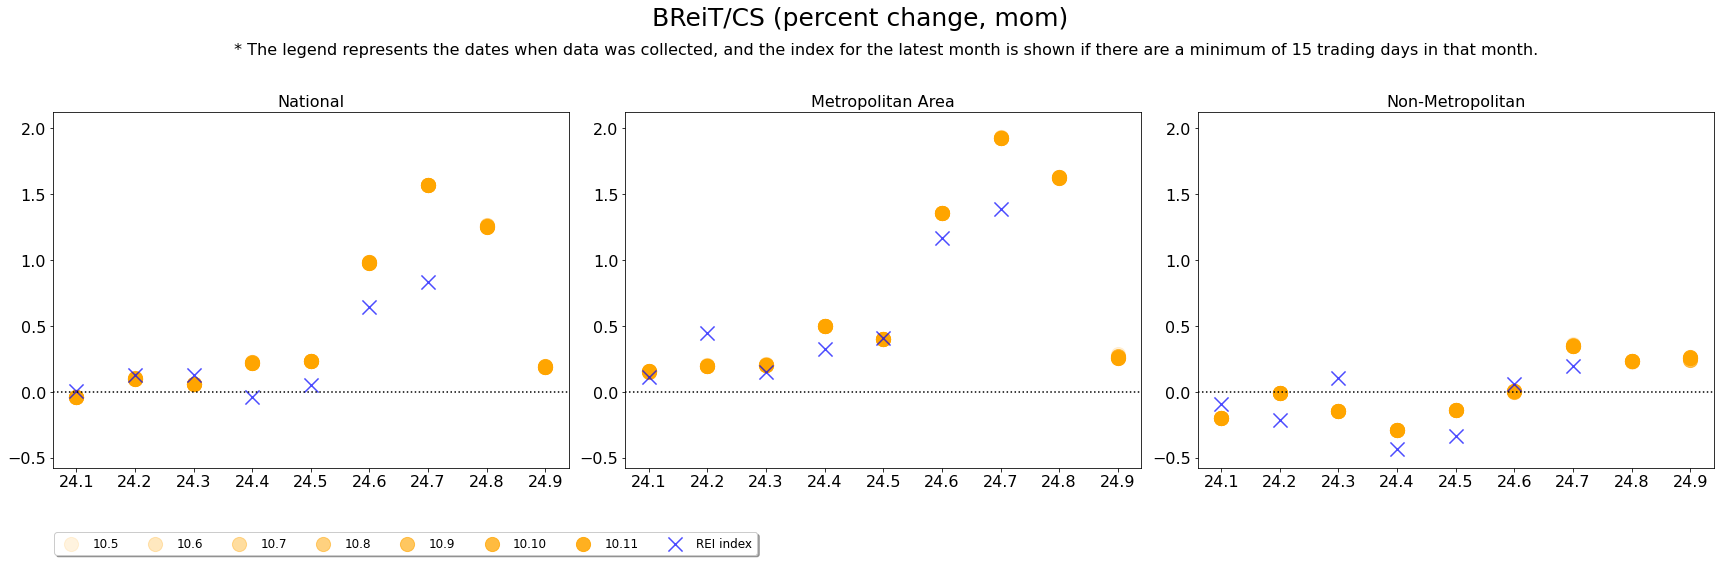

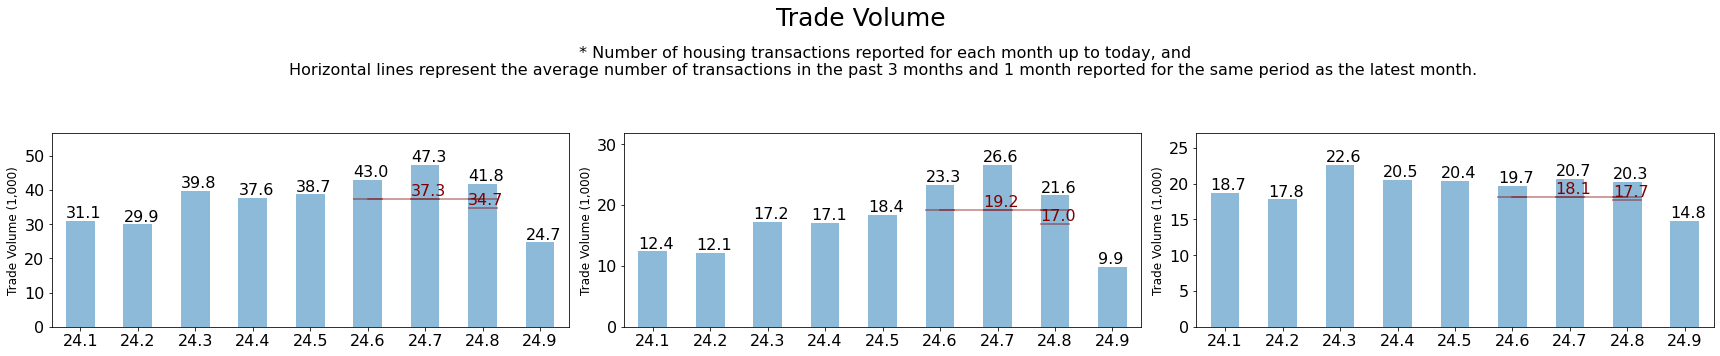

In [2]:
house.plot_by_vintage(plot_rnames = ['N', 'M', 'NM'], # 조회대상지역 N: 전국, M: 수도권(서울, 인천, 경기), NM: 비수도권
                      months = (None, None),          # 최근 9개월간 지수상승률 표시(포함된 거래일이 15일 미만인 월 제외); 예 ('2022-6', '2023-2')
                      vintages = (None, None))        # 최근 1주일간 해당일까지 입수된 거래데이터를 이용하여 계산된 결과 표시; 예 ('2023-2-1', '2023-2-10')

#  **실거래가격지수 계산 코드**

- 국토부 실거래 데이터(일별)에 대해 전처리, 거래쌍 생성, 실거래가격지수 시산 기능을 수행

특정 모듈 내 불러와야 하는 함수나 변수가 많은 경우, 아래와 같이 `import *`를 이용해 한번에 불러올 수 있다.

In [3]:
from bok_da.project.housing.house import *

국토부 실거래가 데이터가 저장된 폴더에서 아파트 매매 데이터가 저장된 파일 리스트를 날짜순으로 정렬하여 files로 입수

In [4]:
files = sorted(fs_anon.glob(s3_bigdatahub_path + 'tb_dw_rtms_at_*.csv.gz'))

가장 최근 10개 데이터 파일에 대해 전처리, 거래쌍 생성, 가격지수 생성하기 위해 vintages로 지정

In [5]:
vintages = [date[-15:-7] for date in files][-8:]
vintages = [date for date in vintages if date not in['20230508', '20240819', '20240820']] # 23.5.8일자 실거래가 데이터 압축파일 오류 
                                                             # 20230708일 이후 데이터에 GW 가 없다- 오류

vintages 기간에 대해 실거래가격지수 계산(이미 계산되어 저장되어 있는 경우 제외)

In [6]:
tic = time.time()
for date in vintages:
    # vintages 리스트에 포함된 날짜중, 실거래가격지수가 생성되어 있지 않은 날짜에 대해 전처리, 거래쌍 생성, 실거래가격지수를 계산
    if fs_anon.isfile(f'{s3_newtech_path}/parquets/IB2s_{date}.parquet.gzip'):  # IB2_yyyymmdd는 yyyy.mm.dd일 빈티지의 케이스-쉴러 지수
        continue
    else:
        print(f"\n{date}:", end=' ')
        print('preprocessing...', end=' ')
        mP = prep_td(f'{s3_bigdatahub_path}/tb_dw_rtms_at_{date}.csv.gz') # 전처리

        print('generating sales pairs...', end=' ')
        y, X, T, HID = gen_yXT(mP.loc[mP.TM.dt.year.ge(syear)]) # 거래쌍 생성
        
        print('calculating indices...', end=' ')
        IBs, IB1s, IB2s = gen_vintage_IBs_update(date, y, X, T, HID, rnames, regions) # 실거래가격지수 계산
        
        vintage_trade_volume = pd.read_pickle(f'{s3_newtech_path}/parquets/vintage_trade_volume.pkl') # 빈티지별 월별 신고된 거래건수 기록  # here!!!!!!!!!!!!!
        df = cal_trade_vol(f'{s3_bigdatahub_path}/tb_dw_rtms_at_{date}.csv.gz')
        vintage_trade_volume = pd.concat([vintage_trade_volume, df], axis=0)
        vintage_trade_volume = vintage_trade_volume.drop_duplicates()
        path = set_store_path()
        vintage_trade_volume.to_pickle(f'{path}/parquets/vintage_trade_volume.pkl')
        
    loop = time.strftime("%H:%M:%S", time.gmtime(time.time() - tic))
    print(f"({loop})", end = ', ')
    tic = time.time()

In [7]:
tic = time.time()
for date in vintages:
    # vintages 리스트에 포함된 날짜중, 실거래가격지수가 생성되어 있지 않은 날짜에 대해 전처리, 거래쌍 생성, 실거래가격지수를 계산
    #if fs_anon.isfile(f'{s3_newtech_path}/parquets/IB2s_{date}.parquet.gzip'):  # IB2_yyyymmdd는 yyyy.mm.dd일 빈티지의 케이스-쉴러 지수
    if fs_anon.isfile(s3_newtech_path  + f'/parquets/IB2s_{date}.parquet.gzip'):
        continue
    else:
        print(f"\n{date}:", end=' ')
        print('preprocessing...', end=' ')
        mP = prep_td(f'{s3_bigdatahub_path}/tb_dw_rtms_at_{date}.csv.gz') # 전처리

        print('generating sales pairs...', end=' ')
        y, X, T, HID = gen_yXT(mP.loc[mP.TM.dt.year.ge(syear)]) # 거래쌍 생성
        
        print('calculating indices...', end=' ')
        IBs, IB1s, IB2s = gen_vintage_IBs_update(date, y, X, T, HID, rnames, regions) # 실거래가격지수 계산
        
        vintage_trade_volume = pd.read_pickle(f'{s3_newtech_path}/parquets/vintage_trade_volume.pkl') # 빈티지별 월별 신고된 거래건수 기록  # here!!!!!!!!!!!!!
        df = cal_trade_vol(f'{s3_bigdatahub_path}/tb_dw_rtms_at_{date}.csv.gz')
        vintage_trade_volume = pd.concat([vintage_trade_volume, df], axis=0)
        vintage_trade_volume = vintage_trade_volume.drop_duplicates()
        path = set_store_path()
        vintage_trade_volume.to_pickle(f'{path}/parquets/vintage_trade_volume.pkl')
        
    loop = time.strftime("%H:%M:%S", time.gmtime(time.time() - tic))
    print(f"({loop})", end = ', ')
    tic = time.time()

### [참고] 케이스-쉴러지수 계산

- 케이스-쉴러지수 관련식
  (출처: S&P Dow Jones Indices: S&P CoreLogic Case-Shiller Home Price Indices Methodology)

    $\beta = (Z'X)^{-1}Z'y $

    $\beta^* = (Z'\Omega^{-1} X)^{-1}Z'\Omega^{-1}y $

    $\Omega[i,i] = \omega_{i,i} = \hat\varepsilon_i^2$, $\varepsilon = y - X'(Z'X)^{-1}Z'y$

# 업데이트된 결과 및 모형코드 저장

분석 코드와 결과를 `output` 폴더에 저장

In [8]:
err_files = create_zip_file()

if len(err_files) != 0:
    print(", ".join(err_files), " 파일 생성 오류")

# 첫번째 셀 plot_by_vintage() 코드

## 셀내 코드를 전체 선택후 코멘트해제(ctrl + /)하여 실행

- 실거래가격지수 상승률을 표시할 지역 : plot_rnames
- 상승률의 첫월과 마지막월 : b_month, e_month
    - b_month = pd.Timestamp('2022-2') : 2022년 2월 상승률부터 표시
- 빈티지 시작일과 마지막일 : v_from, v_to
    - v_from='2022-07-15', v_to='2022-07-29' : 7.15일부터 7.29일까지 입수된 각 데이터를 이용하여 상승률 계산
- 그래프에 포함되는 빈티지 날짜 간격 : v_interval
    - v_interval = 3 : 7.15일부터 7.29일까지 날짜 중 7.15, 7.18, 7.21, ... 에 대해 상승률 표시

In [7]:
# %run house.py                                           # 실거래가격지수 산출에 필요한 라이브러리 입수

# plot_rnames=['N', 'M', 'NM']          # 플롯하려는 지역(17개 광역시도 및 전국, 수도권, 수도권이외 등) 선택

# b_month = pd.Timestamp('2023-2')        # 조회시작월  2022년 2월 -> pd.Timestamp('2022-2')
# e_month = pd.Timestamp('2023-8')       # 조회종료월  2022년 7월 -> pd.Timestamp('2022-7')
# v_from = '2023-8-20'                   # 지수 상승률이 표시되는 빈티지의 시작일 (매월 지수는 15일경 이후 조회시 지수가 안정적 계산됨)
# v_interval = 2

# # [vintage_date_from, vintage_date_to] 범위내에서 IB2s가 계산된 날을 plot_vintages 리스트에 저장
# files = fs_anon.ls(f'{s3_newtech_path}/parquets/')
# ib2s_files = []
# for file in files:
#     if 'IB2s_' in file:
#         ib2s_files.append(file.split('/')[-1])

# ib2s_dates = sorted(ib2s_files)
# ib2s_dates = pd.to_datetime([date[5:13] for date in ib2s_dates[:-62]])
# plot_vintages = [date for date in ib2s_dates if date in pd.date_range(ib2s_dates[-1], v_from, freq=f'-{v_interval}D')]

# # plot_vintages 리스트에 속하는 날에 대해 저장된 IB2s을 모두 불러와 IBs와 IBsCh 생성
# IBs, IBsCh = read_IBs_update(plot_vintages)
# print(ib2s_dates)
# # 부동산원 실거래가지수(rt), 월간매매가격지수(rs) 자동 업데이트
# rt, rt_ch, rs, rs_ch = get_rone_hpi()

# # plot
# fig, ax = plt.subplots(1, len(plot_rnames), figsize=(32, 5))

# alphas = [(i+1)/(len(plot_vintages)+1) for i in range(len(plot_vintages))]  # 색의 흐릿한 정도 설정. 최근 것일 수록 짙게.

# for j, rname in enumerate(plot_rnames):    # 지역명
#     v = None
#     for i, v in enumerate(plot_vintages):  # 빈티지
#         breit = IBsCh[rname].loc[b_month:e_month, v].replace({0.0:np.nan})
#         ax[j].scatter(list(breit.index.strftime('%-y.%-m')), breit.values, label=v, s=200, c='Orange', alpha=alphas[i])  # alpha는 색의 흐릿한 정도
#         ax[j].set_title(NAMETABLE[rname], fontsize=16)
#     rei = rt_ch[rname].loc[b_month:e_month]
#     ax[j].scatter(list(rei.index.strftime('%-y.%-m')), rei.values, marker='x', label=v, s=200, c='b', alpha=.7)  # 지역별 아파트 실거래가 지수 (파란색)

# # legends
# legend_texts = [date.strftime('%-m.%-d') for date in plot_vintages] + ['REI index']
# fig.legend(legend_texts, ncol=15, fontsize=12, loc='lower left', fancybox=True, shadow=True, bbox_to_anchor=(.0, -.15))   # parametrize ncol

# # horizontal line
# for j, rname in enumerate(plot_rnames):
#     ax[j].axhline(y=0, color='k', linestyle=':')
    
# fig.tight_layout();